<a href="https://colab.research.google.com/github/vijin670/Satellite-Super-Resolution-Klymo-Ascent/blob/main/Sentinel_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q worldstrat_2gb.zip -d /content/worldstrat_2gb

In [ ]:
import os
os.listdir("/content/worldstrat_2gb/worldstrat_2gb")

['hr_dataset']

In [ ]:
!pip install torch torchvision opencv-python matplotlib tqdm streamlit pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [ ]:
HR_ROOT = "/content/worldstrat_2gb/worldstrat_2gb/hr_dataset"

hr_images = []

for root, dirs, files in os.walk(HR_ROOT):
    for file in files:
        if file.endswith("_rgb.png"):
            hr_images.append(os.path.join(root, file))

print("Total HR RGB images:", len(hr_images))
print("Sample image:", hr_images[0])

Total HR RGB images: 166
Sample image: /content/worldstrat_2gb/worldstrat_2gb/hr_dataset/12bit/Landcover-249224/Landcover-249224_rgb.png


(np.float64(-0.5), np.float64(1053.5), np.float64(1053.5), np.float64(-0.5))

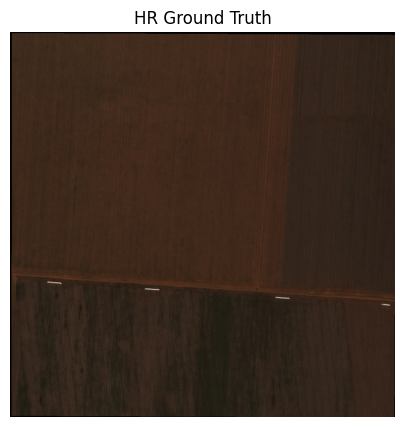

In [ ]:
hr = cv2.imread(hr_images[0])
hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(hr)
plt.title("HR Ground Truth")
plt.axis("off")

(np.float64(-0.5), np.float64(1053.5), np.float64(1053.5), np.float64(-0.5))

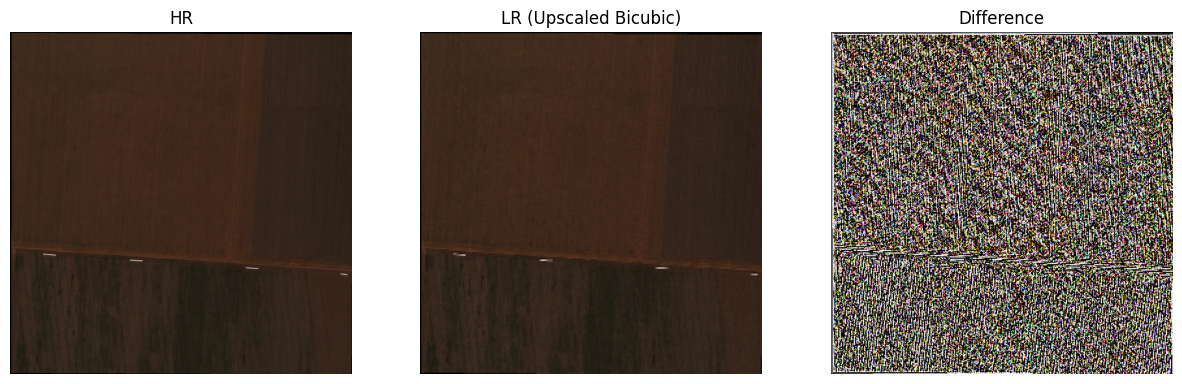

In [ ]:
scale = 4
h, w, _ = hr.shape

lr = cv2.resize(
    hr,
    (w//scale, h//scale),
    interpolation=cv2.INTER_CUBIC
)

lr_up = cv2.resize(
    lr,
    (w, h),
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("HR")
plt.imshow(hr); plt.axis("off")

plt.subplot(1,3,2)
plt.title("LR (Upscaled Bicubic)")
plt.imshow(lr_up); plt.axis("off")

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(abs(hr - lr_up)); plt.axis("off")

In [ ]:
LR_ROOT = "/content/worldstrat_2gb/worldstrat_2gb/lr_dataset"
os.makedirs(LR_ROOT, exist_ok=True)

scale = 4

for path in tqdm(hr_images):
    img = cv2.imread(path)
    h, w, _ = img.shape

    lr = cv2.resize(
        img,
        (w//scale, h//scale),
        interpolation=cv2.INTER_CUBIC
    )

    fname = os.path.basename(path)
    cv2.imwrite(os.path.join(LR_ROOT, fname), lr)

print("LR dataset created!")

100%|██████████| 166/166 [00:09<00:00, 17.23it/s]

LR dataset created!


In [ ]:
class SimpleEDSR(nn.Module):
    def __init__(self, scale=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale, mode='bicubic', align_corners=False)
        self.conv3 = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.upsample(x)
        x = self.conv3(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleEDSR(scale=4).to(device)
model.eval()

SimpleEDSR(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=4.0, mode='bicubic')
  (conv3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
lr_img = cv2.imread(os.path.join(LR_ROOT, os.listdir(LR_ROOT)[0]))
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB) / 255.0

lr_tensor = torch.tensor(lr_img).permute(2,0,1).unsqueeze(0).float().to(device)

with torch.no_grad():
    sr = model(lr_tensor)

sr = sr.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)

(np.float64(-0.5), np.float64(1051.5), np.float64(1051.5), np.float64(-0.5))

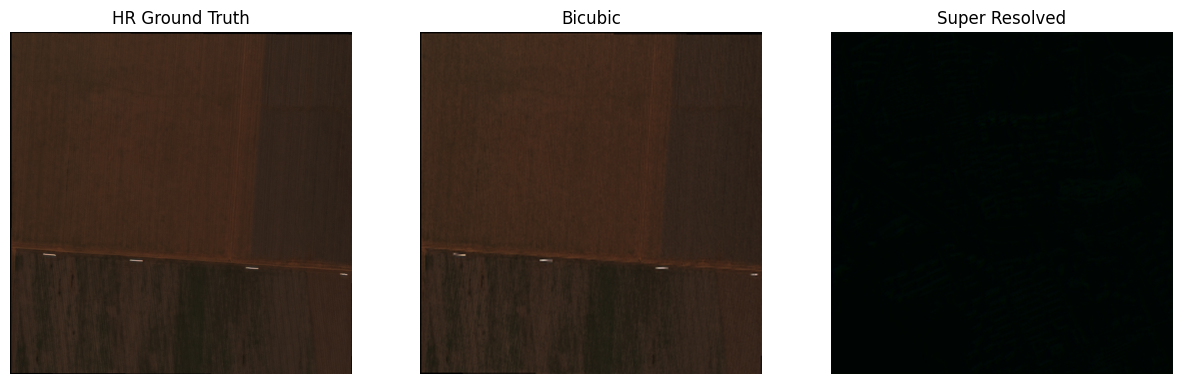

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("HR Ground Truth")
plt.imshow(hr); plt.axis("off")

plt.subplot(1,3,2)
plt.title("Bicubic")
plt.imshow(lr_up/255.0); plt.axis("off")

plt.subplot(1,3,3)
plt.title("Super Resolved")
plt.imshow(sr); plt.axis("off")

In [ ]:
Image.fromarray((sr*255).astype("uint8")).save("/content/sr_output.png")
Image.fromarray(lr_up).save("/content/lr_up.png")

In [ ]:
!pip install gradio opencv-python pillow

In [ ]:
!pip install torch torchvision opencv-python pillow matplotlib tqdm

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_root):
        self.lr_dir = lr_dir
        self.hr_root = hr_root
        self.pairs = []


        hr_map = {}
        for root, _, files in os.walk(hr_root):
            for file in files:
                if file.endswith("_rgb.png"):
                    hr_map[file] = os.path.join(root, file)


        for file in os.listdir(lr_dir):
            if file.endswith("_rgb.png") and file in hr_map:
                lr_path = os.path.join(lr_dir, file)
                hr_path = hr_map[file]
                self.pairs.append((lr_path, hr_path))

        print(f"✔ Matched LR–HR pairs: {len(self.pairs)}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lr_path, hr_path = self.pairs[idx]

        lr = cv2.imread(lr_path)
        hr = cv2.imread(hr_path)

        if lr is None or hr is None:
             raise ValueError("Failed to load image")

        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)


        h, w, _ = hr.shape
        lr = cv2.resize(lr, (w, h), interpolation=cv2.INTER_CUBIC)

        crop_size = 128

        h_crop, w_crop, _ = hr.shape
        if h_crop > crop_size and w_crop > crop_size:
            x = np.random.randint(0, w_crop - crop_size)
            y = np.random.randint(0, h_crop - crop_size)

            lr = lr[y:y+crop_size, x:x+crop_size]
            hr = hr[y:y+crop_size, x:x+crop_size]

        lr = torch.from_numpy(lr).permute(2, 0, 1).float() / 255.0
        hr = torch.from_numpy(hr).permute(2, 0, 1).float() / 255.0

        return lr, hr




In [ ]:
lr_path = "/content/worldstrat_2gb/worldstrat_2gb/lr_dataset"
hr_path = "/content/worldstrat_2gb/worldstrat_2gb/hr_dataset/12bit"

dataset = SuperResolutionDataset(lr_path, hr_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


✔ Matched LR–HR pairs: 166


In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for lr, hr in tqdm(dataloader):
        lr, hr = lr.to(device), hr.to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss / len(dataloader):.4f}")


100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


Epoch [1/5] Loss: 0.0170


100%|██████████| 42/42 [00:30<00:00,  1.38it/s]


Epoch [2/5] Loss: 0.0041


100%|██████████| 42/42 [00:31<00:00,  1.35it/s]


Epoch [3/5] Loss: 0.0037


100%|██████████| 42/42 [00:31<00:00,  1.33it/s]


Epoch [4/5] Loss: 0.0027


100%|██████████| 42/42 [00:30<00:00,  1.37it/s]

Epoch [5/5] Loss: 0.0024


In [ ]:
torch.save(model.state_dict(), "srcnn_worldstrat.pth")
print("Model saved as srcnn_worldstrat.pth")


Model saved as srcnn_worldstrat.pth


In [ ]:
def super_resolve_image(lr_image_path, hr_image_path, model):
    model.eval()


    lr = cv2.imread(lr_image_path)
    hr = cv2.imread(hr_image_path)

    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)


    h, w, _ = hr.shape
    lr_up = cv2.resize(lr, (w, h), interpolation=cv2.INTER_CUBIC)


    lr_tensor = torch.from_numpy(lr_up).permute(2, 0, 1).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        sr = model(lr_tensor)

    sr = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    sr = np.clip(sr, 0, 1)

    return lr_up, sr, hr


In [ ]:
import cv2
import torch
import numpy as np

def super_resolve_image(lr_path, hr_path, model):

    lr = cv2.imread(lr_path)
    hr = cv2.imread(hr_path)

    if lr is None or hr is None:
        raise ValueError("Failed to load LR or HR image")

    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)


    lr_small = cv2.resize(lr, (128, 128), interpolation=cv2.INTER_CUBIC)


    lr_tensor = (
        torch.from_numpy(lr_small)
        .permute(2, 0, 1)
        .float()
        .unsqueeze(0)
        / 255.0
    ).to(device)

    model.eval()
    with torch.no_grad():
        sr = model(lr_tensor)

    # Post-process SR
    sr = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()
    sr = (sr * 255).clip(0, 255).astype(np.uint8)

    # Resize SR back to HR size
    sr = cv2.resize(sr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)

    return lr, sr, hr


In [ ]:
lr_img_path = dataset.pairs[0][0]
hr_img_path = dataset.pairs[0][1]

lr_img, sr_img, hr_img = super_resolve_image(
    lr_img_path, hr_img_path, model
)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Low Resolution (Input)")
plt.imshow(lr_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Super Resolved (SRCNN)")
plt.imshow(sr_img)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("High Resolution (Ground Truth)")
plt.imshow(hr_img)
plt.axis("off")

plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

SRCNN(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [3]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import gradio as gr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, 5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to(device)
model.eval()

def super_resolve(img):
    img = np.array(img)
    img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
    img = img.astype(np.float32) / 255.0
    x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        y = model(x)

    y = y.squeeze().permute(1, 2, 0).cpu().numpy()
    y = (y * 255).astype(np.uint8)
    return y

demo = gr.Interface(
    fn=super_resolve,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="numpy"),
    title="Satellite Image Super-Resolution"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7286ccb8fafb589643.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
